# Genetic Algorithm through Conventional Machine Learning approach for Classification

<strong>Akmal Muzakki Bakir (1305210087)</strong>

## Library Preparation

In [70]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from tqdm import tqdm

## Dataset Preparation

In [71]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [73]:
# Pembagian data training
y_train = df['class']
x_train = df.drop('class', axis=1)

le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])
y_train = le.fit_transform(y_train)

In [74]:
# Menentukan jumlah fitur secara otomatis
ohe = OneHotEncoder(categories='auto')
sc = StandardScaler()

# Pengubahan data ke dalam bentuk array
x_train = ohe.fit_transform(x_train).toarray()

# Normalisasi data
x_train = sc.fit_transform(x_train)

In [75]:
# Pembagian data training, validasi, dan testing
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

## Artificial Neural Network Architecture

In [76]:
class ActivationFunction:
    # Mendefinisiakan fungsi 
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Mendefinisikan fungsi aktivasi relu
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

In [77]:
class NeuralNetwork:
    # Mendefinisikan fungsi untuk melakukan propagasi maju
    @staticmethod
    def forward(x, w, activation):
        return activation(np.matmul(x, w))

    # Mendefiniskan fungsi untuk menghitung akurasi prediksi
    @staticmethod
    def accuracy_fn(y, y_hat):
        return (np.where(y == y_hat)[0].size / y_hat.size)

    # Mendefinisikan fungsi untuk melakukan prediksi menggunakan jaringan saraf yang telah dilatih
    @staticmethod
    def predict(x, y_hat, weights, activation):
        predictions = np.zeros(shape=(x.shape[0]))
        
        # Loop untuk melakukan prediksi pada setiap data
        for idx in range(x.shape[0]):
            r1 = x[idx, :]
            
            # Melakukan propagasi maju melalui setiap lapisan menggunakan bobot yang telah dilatih
            for curr_weights in weights:
                r1 = forward(r1, curr_weights, activation)
            # Mengambil label kelas dengan nilai prediksi tertinggi sebagai hasil prediksi
            predictions[idx] = np.where(r1 == np.max(r1))[0][0]

        # Menghitung akurasi prediksi
        accuracy = accuracy_fn(predictions, y_hat)
        return accuracy, predictions

    # Mendefinisikan fungsi untuk menghitung akurasi untuk setiap set bobot
    @staticmethod
    def fitness(x, y_hat, weights, activation):
        accuracy = np.empty(shape=(weights.shape[0]))
        
        # Loop melalui setiap individu dalam populasi dan menghitung akurasinya
        for idx in range(weights.shape[0]):
            accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
        return accuracy

### Vector-Matrix Manipulations

In [78]:
# Mendefiniskan fungsi untuk mengonversi matriks bobot menjadi representasi vektor
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    
    # Loop melalui setiap individu dalam populasi
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        
        # Loop melalui setiap lapisan dalam individu
        for layer_idx in range(mat_pop_weights.shape[1]):
            # Mengubah matriks bobot menjadi vektor
            vector_weights = np.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        # Menambahkan vektor bobot individu ke dalam array
        pop_weights_vector.append(curr_vector)
    
    # Mengembalikan array berisi vektor bobot individu
    return np.array(pop_weights_vector)

# Mendefinisikan fungsi untuk mengonversi representasi vektor menjadi matriks bobot
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    
    # Loop melalui setiap individu dalam populasi
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        
        # Loop melalui setiap lapisan pada individu
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            # Memotong vektor sesuai dengan lapisan ukuran matriks bobot
            curr_vector = vector_pop_weights[sol_idx, start:end]
            # Mengubah vektor menjadi matriks bobot
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    
    # Mengembalikan array berisi matriks bobot populasi yang telah dikembalikan ke bentuk semula  
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

## Genetic Algorithm Architecture

In [79]:
class GeneticAlgorithm:    
    # Mendefinisikan fungsi untuk memilih individu-individu dalam populasi yang akan digunakan sebagai orangtua untuk reproduksi
    @staticmethod
    def mating_pool(pop, fitness, num_parents):
        parents = np.empty((num_parents, pop.shape[1]))
        
        # Memilih individu-orangtua dengan nilai fitness tertinggi untuk reproduksi
        for parent_num in range(num_parents):
            max_fitness_idx = np.where(fitness == np.max(fitness))
            max_fitness_idx = max_fitness_idx[0][0]
            parents[parent_num, :] = pop[max_fitness_idx, :]
            fitness[max_fitness_idx] = -99
            
        return parents
    
    # Mendefinisikan fungsi untuk melakukan operasi crossover pada individu-individu orangtua
    @staticmethod
    def crossover(parents, offspring_size):
        offspring = np.empty(offspring_size)
        crossover_point = np.uint32(offspring_size[1]/2)

        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]
            
            # Memilih bagian genetik dari kedua orangtua untuk digabungkan
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
            
        return offspring

    # Mendefinisikan fungsi untuk melakukan mutasi pada individu-individu hasil operasi crossover
    @staticmethod
    def mutation(offspring_crossover, mutation_percent):
        num_mutations = np.uint32((mutation_percent * offspring_crossover.shape[1]))
        mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
        
        for idx in range(offspring_crossover.shape[0]):
            # Menambahkan nilai acak pada gen-gen yang mengalami mutasi
            random_value = np.random.uniform(-1.0, 1.0, 1)
            offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
        
        return offspring_crossover

### Parameters

In [80]:
# Inisialisasi parameter
solution_per_population = 8 # Jumlah individu dalam satu populasi
num_parents_mating = 4 # Jumlah individu-orangtua yang akan digunakan untuk reproduksi
num_generations = 100 # Jumlah generasi yang akan dilatih
mutation_percent = 0.20 # Persentase individu yang akan mengalami mutasi

In [81]:
# Inisialisasi ukuran input dan output
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

### Weight Initialization

In [82]:
def weight_initialization(solution_per_population, input_shape, output_shape):    
    initial_weights = []
    # Untuk setiap individu dalam populasi
    for _ in np.arange(0, solution_per_population):
        
        # Inisialisasi bobot secara acak
        w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
        w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
        w3 = np.random.uniform(low=-0.1, high=0.1, size=(64, output_shape))

        initial_weights.append(np.array([w1, w2, w3]))
    
    # Mengembalikan array berisi matriks bobot populasi
    return np.array(initial_weights)

In [83]:
weights_mat = weight_initialization(solution_per_population, input_shape, output_shape)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

C:\Users\akmal\AppData\Local\Temp\ipykernel_5864\483491245.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_weights.append(np.array([w1, w2, w3]))


In [84]:
af = ActivationFunction()
nn = NeuralNetwork()
ga = GeneticAlgorithm()

## Training

In [85]:
for generation in tqdm(range(num_generations)):
    # Melakukan konversi vektor bobot kembali menjadi bentuk matriks bobot
    weights_mat = vector_to_mat(weights_vector, weights_mat)
    # Menghitung nilai fitness untuk setiap individu dalam populasi
    fit = nn.fitness(x_train, y_train, weights_mat, activation=sigmoid)
    # Menyimpan nilai akurasi dari populasi saat ini
    accuracies[generation] = fit[0]
    # Memilih individu-orangtua dari populasi saat ini, dimana individu-orangtua yang memiliki nilai fitness tertinggi akan dipilih
    parents = ga.mating_pool(weights_vector, fit.copy(), num_parents_mating)
    # Melakukan operasi crossover untuk menghasilkan keturunan pada individu-orangtua yang telah dipilih
    offspring_crossover = ga.crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))
    # Melakukan operasi mutasi pada keturunan yang telah dihasilkan
    offspring_mutation = ga.mutation(offspring_crossover, mutation_percent=mutation_percent)
    # Menggantikan individu-individu dalam populasi dengan keturunan yang telah dihasilkan dan menyusun kembali populasi dari langkah awal
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\akmal\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


100%|██████████| 100/100 [16:39<00:00,  9.99s/it]


## Analysis

In [86]:
# Analisis hasil pelatihan
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = nn.predict(x_train, y_train, best_weights, activation=sigmoid)
print("Accuracy of the best solution is : ", acc)
print("Predictions : ", predictions)

Accuracy of the best solution is :  0.8746042912416462
Predictions :  [1. 0. 1. ... 0. 1. 0.]


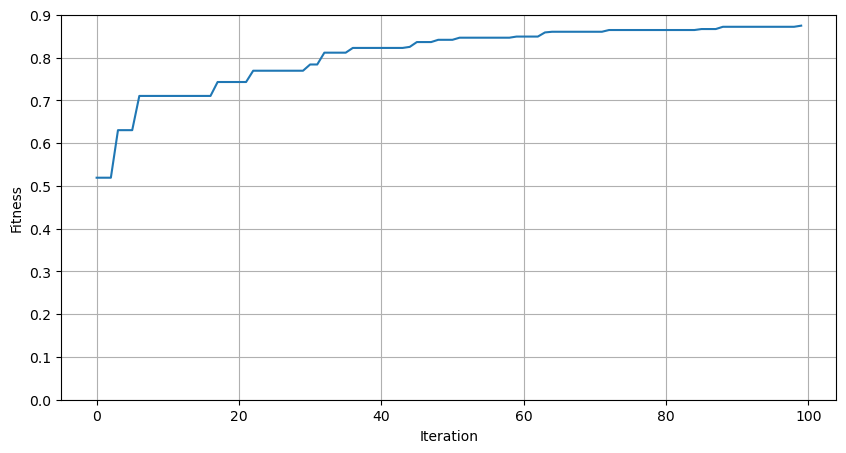

In [87]:
# Memvisualisasikan akurasi prediksi pada setiap generasi
plt.figure(figsize=(10, 5))
plt.plot(accuracies)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

## References

https://www.linkedin.com/pulse/introduction-optimization-genetic-algorithm-ahmed-gad/
>
https://www.kdnuggets.com/2018/03/introduction-optimization-with-genetic-algorithm.html
>
https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b
>
https://www.springer.com/us/book/9781484241660